In [1]:
# add command for jupyter to reload modules automatically
%load_ext autoreload
%autoreload 2

In [2]:
import json
from pathlib import Path
import random
import pprint

import matplotlib
import matplotlib.pyplot as plt

import os

import torch
from torch.nn import functional as F

from config import load_config
from data import CLEVRSplit, CLEVRMultimodalSplit, CLEVRTextSplit, Scene, CollatorForMaskedLanguageModeling
from model import MultimodalModelForImagePretraining, ImageMaskingPretrainingModel
from lightning import Trainer, seed_everything
from tqdm.auto import tqdm, trange

from PIL import Image

from torch.utils.data import DataLoader, Subset
from torch.nn.functional import softmax


pp = pprint.PrettyPrinter(indent=2)

In [3]:
from torch.utils.data import default_collate

class CollatorForMaskedSelectedTokens:
    def __init__(self, config, processor, tokens):
        self.config = config
        self.token_to_mask_idxs = torch.tensor(tokens)
        self.special_token_idxs = torch.tensor(processor.special_token_idxs)
        self.mask_token_idx = processor.mask_token_idx
        self.image_patch_sizes = config.patch_height, config.patch_width

    def __call__(self, batch):
        images, scenes = default_collate(batch)
        scenes, scenes_labels = self.build_targets(scenes)
        images_labels = self.build_null_image_targets(images)
        labels = torch.cat((images_labels, scenes_labels), dim=1)
        return images, scenes, labels

    def build_null_image_targets(self, images):
        b, c, h, w = images.shape
        n_patches = config.n_patches
        return torch.full((b, n_patches), -100)

    def build_targets(self, inputs):
        labels = inputs.clone()
        masked_indices = torch.isin(labels, self.token_to_mask_idxs)
        labels[~masked_indices] = -100
        inputs[masked_indices] = self.mask_token_idx
        
        return inputs, labels

    
class CollatorForMaskedRandomSelectedTokens:
    def __init__(self, config, processor, tokens, p):
        self.config = config
        self.token_to_mask_idxs = torch.tensor(tokens)
        self.special_token_idxs = torch.tensor(processor.special_token_idxs)
        self.mask_token_idx = processor.mask_token_idx
        self.image_patch_sizes = config.patch_height, config.patch_width
        self.p = p

    def __call__(self, batch):
        images, scenes = default_collate(batch)
        scenes, scenes_labels = self.build_targets(scenes)
        images_labels = self.build_null_image_targets(images)
        labels = torch.cat((images_labels, scenes_labels), dim=1)
        return images, scenes, labels

    def build_null_image_targets(self, images):
        b, c, h, w = images.shape
        n_patches = config.n_patches
        return torch.full((b, n_patches), -100)

    def build_targets(self, inputs):
        labels = inputs.clone()
        masked_indices = torch.isin(labels, self.token_to_mask_idxs)
        is_selected = torch.bernoulli(torch.full_like(labels, self.p, dtype=torch.float)).bool()
        masked_indices = masked_indices & is_selected 
        labels[~masked_indices] = -100
        inputs[masked_indices] = self.mask_token_idx
        
        return inputs, labels
    

class IdentityCollator:
    def __init__(self, config, processor):
        self.config = config
        self.special_token_idxs = torch.tensor(processor.special_token_idxs)
        self.image_patch_sizes = config.patch_height, config.patch_width

    def __call__(self, batch):
        images, scenes = default_collate(batch)
        scenes, scenes_labels = self.build_targets(scenes)
        images_labels = self.build_null_image_targets(images)
        labels = torch.cat((images_labels, scenes_labels), dim=1)
        return images, scenes, labels

    def build_null_image_targets(self, images):
        b, c, h, w = images.shape
        n_patches = config.n_patches
        return torch.full((b, n_patches), -100)

    def build_targets(self, inputs):
        labels = inputs.clone()
        special_token_indices = torch.isin(labels, self.special_token_idxs)
        labels[special_token_indices] = -100
        
        return inputs, labels

In [4]:
# from config import load_config
    
# config = load_config()
# config.shuffle_object_identities = True
# config.display_object_properties = False

In [5]:
# config_to_copy = {
#     'base_path': '/workspace1/fidelrio/CLEVR_CoGenT_v1.0',
#     'batch_size': 64,
#     'd_hidden': 256,
#     'display_object_properties': False,
#     'filter_symmetric_relations': True,
#     'lr': 0.01,
#     'max_epochs': 200,
#     'max_question_size': 45,
#     'max_scene_size': 659,
#     'n_head': 4,
#     'n_layers': 4,
#     'n_outputs': 28,
#     'n_patches': 100,
#     'n_tokens': 117,
#     'only_front_right_relations': True,
#     'pad_idx': 1,
#     'patch_height': 32,
#     'patch_width': 48,
#     'rels_to_sample': 50,
#     'resume_training': False,
#     'use_txt_scene': True,
#  }

# for k, v in vars(config).items():
#     if k in config_to_copy and config_to_copy[k] != v:
#         print(k, v, config_to_copy[k])

In [6]:
def scene_tensor_to_txt(tensor):
    return ' '.join([processor.inv_vocabulary[t] for t in tensor.tolist()])

def print_scene_tensor(tensor):
    scene_text = scene_tensor_to_txt(tensor)
    print(scene_text.replace('[PAD]', '').replace('[SEP]','\n     '))
    
def print_parallel(tensor0, tensor1, tensor2, confidences, titles):
    ttl0, ttl1, ttl2 = titles
    print(f'{ttl0:6.6s} {ttl1:6.6s} {ttl2:6.6s}')
    for t0, t1, t2, conf in zip(
            tensor0.tolist(), tensor1.tolist(), tensor2.tolist(), confidences.tolist()):
        w0 = processor.inv_vocabulary[t0]
        w1 = processor.inv_vocabulary[t1]
        w2 = processor.inv_vocabulary[t2]
        
        if w0 == '[SEP]':
            print()
            continue
        if w0 == '[PAD]':
            break
        
        print_txt = f'{w0:6.6s} {w1:6.6s} {w2:6.6s} ({conf:.4f})'
        if w0 != w2:
            print_txt = bold(print_txt)
            

        print(print_txt)
        
def bold(text):
    return ("\033[1m" + text + "\033[0m")

In [7]:
strip_ = lambda x: x.replace('last','').replace('.ckpt','').replace('-v','')
key_ = lambda p: int(strip_(p.name) if strip_(p.name) else 0)

# exp_name = 'multimodal-pretraining--mlm_probability=0.15--rels_to_sample=5--vit'
# exp_name = 'multimodal-pretraining--mlm_probability=0.15--rels_to_sample=5--vit-frozen--long'
# exp_name = 'multimodal-pretraining--mlm_probability=0.15--rels_to_sample=5--vit-frozen--aug_zero_indep=100'
# exp_name = 'image-pretraining--mp_probability=0.75--rels_to_sample=5-v2'
exp_name = 'image-pretraining--mp_probability=0.75--no-scene-v2'

# resume_from_path = f'outputs/{exp_name}/last.ckpt'
# resume_from_path = f'outputs/{exp_name}/last-v1.ckpt'
# resume_from_path = f'outputs/{exp_name}/epoch=500-step=68637.ckpt'
all_ckpts = Path(f'outputs/{exp_name}/').glob('last*.ckpt')
resume_from_path = str(sorted(all_ckpts, key=key_)[-1])

checkpoint = torch.load(resume_from_path)

print('Epoch:', checkpoint['epoch'])

Epoch: 987


In [8]:
# !ls outputs/$exp_name
# !ls outputs/

In [9]:
config = load_config(exp_name)

Loading image-pretraining--mp_probability=0.75--no-scene-v2 last checkpoint config from outputs/image-pretraining--mp_probability=0.75--no-scene-v2/last.ckpt
Add new arg: aug_zero_color = False
Add new arg: token_translation_path = 
Add new arg: use_curriculum = False
Add new arg: use_vit_embedding_loaded = False
Add new arg: use_embedding_loaded = 
Add new arg: adapt_embedding_from = 0


In [10]:
pp.pprint(vars(config))

{ 'adapt_embedding_from': 0,
  'aug_zero': 0,
  'aug_zero_color': False,
  'aug_zero_independent': False,
  'base_path': '/workspace1/fidelrio/CLEVR_CoGenT_v1.0',
  'batch_size': 256,
  'comet_experiment_key': '0244e3320983482b8ff59c5a797de5eb',
  'd_hidden': 256,
  'display_object_properties': False,
  'filter_symmetric_relations': True,
  'freeze_vit_embedding': False,
  'image_pretraining': True,
  'lr': 0.0001,
  'max_epochs': 1000,
  'max_question_size': 45,
  'max_scene_size': 0,
  'mlm_probability': 0.15,
  'mp_probability': 0.75,
  'multimodal_pretraining': False,
  'multimodal_training': False,
  'n_head': 4,
  'n_layers': 4,
  'n_outputs': 28,
  'n_patches': 196,
  'n_tokens': 98,
  'not_normalize_image': True,
  'only_front_right_relations': False,
  'optimizer': 'adam',
  'pad_idx': 1,
  'patch_height': 16,
  'patch_width': 16,
  'profile': False,
  'rels_to_sample': 0,
  'resume_training': False,
  'seed': 42,
  'shuffle_object_identities': True,
  'start_from': '',
  'tok

In [11]:
if '/workspace/' in config.base_path or '/workspace/' in config.vocabulary_path:
    config.base_path = '/workspace1/fidelrio/CLEVR_CoGenT_v1.0'
    config.vocabulary_path =  '/workspace1/fidelrio/CLEVR_CoGenT_v1.0/vocab.txt'

In [16]:
train_dataset, test_dataset, systematic_dataset, _ = CLEVRMultimodalSplit.build_splits(
    config
)

In [17]:
model = MultimodalModelForImagePretraining(config)
training_model = ImageMaskingPretrainingModel(model, config)
training_model.load_state_dict(checkpoint['state_dict'])

/home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/lightning/pytorch/utilities/parsing.py:270: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


<All keys matched successfully>

In [19]:
processor = test_dataset.processor

In [20]:
relation_tokens = sorted([processor.vocabulary[w] for w in ['left', 'right', 'behind', 'front']])
color_tokens = sorted([processor.vocabulary[w] for w in 
                       ['blue', 'brown', 'cyan', 'green', 'red', 'purple', 'yellow', 'gray']])
shapes_tokens = sorted([processor.vocabulary[w] for w in ['cylinder', 'sphere', 'cube']])
materials_tokens = sorted([processor.vocabulary[w] for w in ['metal', 'rubber']])
size_tokens = sorted([processor.vocabulary[w] for w in ['small', 'large']])

In [21]:
relation_tokens

[26, 45, 57, 75]

In [22]:
# collator = CollatorForMaskedLanguageModeling(config, processor)
# collator = CollatorForMaskedSelectedTokens(config, processor, tokens=materials_tokens)
# collator = CollatorForMaskedRandomSelectedTokens(config, processor, tokens=relation_tokens, p=0.2)
# collator = IdentityCollator(config, processor)

In [23]:
dataset = test_dataset
sample_idx = 333

# sample_idx = random.randint(0, len(dataset))
image, scene = dataset.retrieve_raw(sample_idx)
image_tensor, scene_tensor = dataset[sample_idx]

# collated_images, collated_scenes, collated_labels = collator([(image_tensor, scene_tensor)])

print(sample_idx)

333


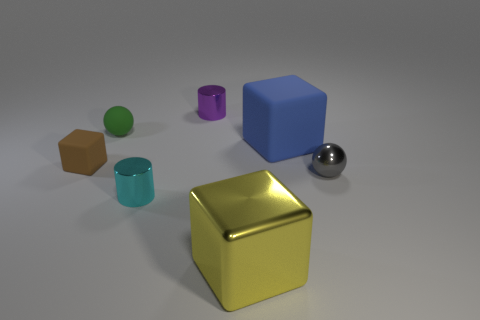

In [24]:
print_scene_tensor(scene_tensor)
print()
# print_scene_tensor(collated_scenes[0])

image

In [25]:
# collated_scenes.shape

In [26]:
image, scene = image_tensor.unsqueeze(0), scene_tensor.unsqueeze(0)

patches = training_model._to_patches(image)
n_patches = patches.size(1)
mask, masked_combined = training_model._sample_mask(patches, scene, p=training_model.config.mp_probability)

In [27]:
output = model(patches, scene, mask)

# output_logits.reshape(1,277,101,98).sum(-2)

# confidences = softmax(output_logits, dim=-1).max(dim=-1).values
# predictions = output_logits.argmax(dim=-1)

In [28]:
output_patches = output[:,:n_patches,:]
loss = F.mse_loss(output_patches, patches, reduction='none').mean(-1)
loss.masked_fill_(mask, value=0.0)
loss = loss.mean()

In [29]:
print('Loss:', loss.item())

Loss: 0.00041626309393905103


In [30]:
patches.shape, mask.shape

(torch.Size([1, 196, 768]), torch.Size([1, 196]))

In [31]:
masked_patches = patches.masked_fill(mask.unsqueeze(-1), value=0.0)

In [32]:
def plot_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.plot()

[]

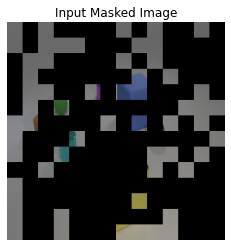

In [43]:
plt.imshow(training_model._to_image(masked_patches)[0].permute(1,2,0))
plt.axis('off')
plt.title('Input Masked Image')
plt.plot()

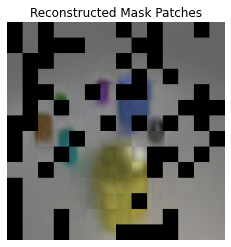

In [44]:
plot_image(
    training_model._to_image(
        output_patches.detach().masked_fill(~mask.unsqueeze(-1), value=0.0))[0].permute(1,2,0))

plt.title('Reconstructed Mask Patches')
plt.show()

[]

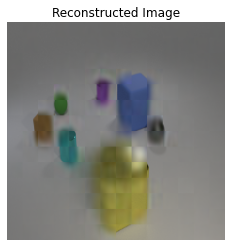

In [39]:
reconstructed_image = (output_patches.detach().masked_fill(~mask.unsqueeze(-1), value=0.0)
                        + masked_patches.masked_fill(mask.unsqueeze(-1), value=0.0))

plt.imshow(training_model._to_image(reconstructed_image)[0].permute(1,2,0))
plt.axis('off')
plt.title('Reconstructed Image (Masks are replaced)')
plt.plot()

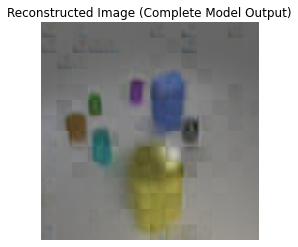

In [41]:
plot_image(training_model._to_image(output_patches.detach())[0].permute(1,2,0))
plt.title('Reconstructed Image (Complete Model Output)')
plt.show()

In [ ]:
dataset_path = Path('/mnt/ialabnas/datasets/CLEVR_CoGenT_v1.0')
scenes_path = dataset_path / 'scenes/CLEVR_trainA_scenes.json'
with scenes_path.open('r') as fp:
    scenes = json.load(fp)
    
questions_path = dataset_path / 'questions/CLEVR_trainA_questions.json'
with questions_path.open('r') as fp:
    questions = json.load(fp)

In [ ]:
questions['questions'][3]

In [ ]:
def n_relations(scene):
    relations = ['behind', 'front']#, 'left', 'right']
    count = 0
    relationships = scene['relationships']
    for r in relations:
        count += sum(map(len, relationships[r]))
    return count

n_relations(scenes['scenes'][0])

In [ ]:
(scenes['scenes'][0])

In [ ]:
n_relations_per_example = list(map(n_relations, scenes['scenes']))
plt.hist(n_relations_per_example)
plt.plot()

In [ ]:
def n_objects(scene):
    return len(scene['objects'])

In [ ]:
n_objects_per_example = list(map(n_objects, scenes['scenes']))
plt.hist(n_objects_per_example, bins=max(n_objects_per_example)-3)
plt.plot()

In [ ]:
def object_to_text(obj, obj_idx):
    properties = ['size', 'color', 'material', 'shape']
    obj_str = [f'[O{obj_idx}]'] + [obj[prop] for prop in properties]
    return ' '.join(obj_str)

def relations_to_text(relations):
#     relation_types = ['behind', 'front', 'left', 'right']
    relation_types = ['front', 'right'] # symetric relations

    relations_str = []
    for relation_type in relation_types:
        relation = relations[relation_type]
        for obj, subjs in enumerate(relation):
            relation_str = [f'[O{obj}] {relation_type} [O{subj}]' for subj in subjs]
            relations_str.extend(relation_str)
    
    return relations_str

def scene_to_txt(scene, rels_to_sample=None, shuffle=True):
    objs_strs = []
    for obj_idx, obj in enumerate(scene['objects']):
        objs_strs.append(object_to_text(obj, obj_idx=obj_idx))
    
    relations_strs = relations_to_text(scene['relationships'])
    if rels_to_sample and rels_to_sample < len(relations_strs):
        relations_strs = random.sample(relations_strs, k)
    if shuffle:
        random.shuffle(relations_strs)

    return ' [SEP] '.join(objs_strs + relations_strs)

In [ ]:
from PIL import Image
ip = '/mnt/ialabnas/datasets/CLEVR_CoGenT_v1.0/images/trainA/' + questions['questions'][8888]['image_filename']
Image.open(ip)

In [ ]:
object_to_text(scenes['scenes'][8888]['objects'][0], obj_idx=0)

In [ ]:
object_to_text(scenes['scenes'][8888]['objects'][1], obj_idx=1)

In [ ]:
relations_to_text(scenes['scenes'][8888]['relationships'])

In [ ]:
scene_to_txt(scenes['scenes'][8888])

In [ ]:
# scene_to_txt(scenes['scenes'][8888], rels_to_sample=5)

In [ ]:
to_str = lambda s: str(Scene.from_dict(s, 
                                        relations_to_sample=config.rels_to_sample,
                                        only_front_right=config.only_front_right_relations,
                                        filter_symmetric=config.filter_symmetric_relations,
                                        always_display_properties=config.display_object_properties))

str_len_per_example = list(map(len, map(str.split, map(to_str, scenes['scenes']))))
plt.hist(str_len_per_example)
plt.plot()

In [ ]:
str_fnc = lambda s: str(Scene.from_dict(s, relations_to_sample=50,
                                        only_front_right=config.only_front_right_relations,
                                        filter_symmetric=config.filter_symmetric_relations,
                                        always_display_properties=config.display_object_properties))

str_len_per_example = list(map(len, map(str.split, map(str_fnc, scenes['scenes']))))
plt.hist(str_len_per_example)
plt.plot()

In [ ]:
vocabulary = set()
for scene in scenes['scenes']:
    scene_text = scene_to_txt(scene)
    vocabulary.update(scene_text.split())

vocabulary = ['[CLS]', '[PAD]'] + list(sorted(vocabulary))

In [ ]:
len(vocabulary), vocabulary